In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from datasets import load_dataset
import torch
import torch.nn as nn
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
from transformers import AutoTokenizer
import numpy as np
from transformers import Trainer, TrainingArguments
from torch.utils.data import Dataset,DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve,auc
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from transformers import DistilBertModel, DistilBertConfig
from sklearn.metrics import classification_report
from nltk.util import ngrams
from gensim.models import Word2Vec
from time import time  # To time our operations
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,Flatten,Permute
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
from tensorflow import keras
from tensorflow.keras import layers
from tabnanny import verbose
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
import seaborn as sn

In [2]:
emotions = load_dataset('emotion')

emotions.set_format('pandas')
df = emotions['train'][:]
df.head()

def label_int2str(row):
    return emotions['train'].features['label'].int2str(row)

df['label_name'] = df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [3]:
text_list_p=df["text"].tolist()
labels_p=df["label_name"].tolist()

text_list=[]
labels=[]
for i in range(len(labels_p)):
    if text_list_p[i]!='':
        text_list.append(text_list_p[i])
        labels.append(labels_p[i])

labels=np.array(labels)

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
num_classes=int(np.max(integer_encoded)+1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
mapping = dict(zip(label_encoder.classes_, onehot_encoder.transform(label_encoder.transform(label_encoder.classes_).reshape(num_classes, 1))))
for key,value in mapping.items():
    print("",key," -----------------------------> ",value)



# randomly create indices for train and test
indices = np.arange(len(text_list))
np.random.shuffle(indices)
splitter=0.6
train_indices = indices[:int(splitter*len(text_list))]
test_indices = indices[int(splitter*len(text_list)):]
text_list_train = np.array(text_list)[train_indices]
text_list_test = np.array(text_list)[test_indices]
labels_train = np.array(labels)[train_indices]
labels_test = np.array(labels)[test_indices]
onehot_encoded_train = np.array(onehot_encoded)[train_indices]
onehot_encoded_test = np.array(onehot_encoded)[test_indices]
integer_encoded_train = np.array(integer_encoded)[train_indices]
integer_encoded_test = np.array(integer_encoded)[test_indices]




# doing for text_list_train
omega_text_words_train = []
n=1
for i in range(len(text_list_train)):
    sentence=text_list_train[i]
    unigrams = ngrams(sentence.split(), n)
    flat_list = [item for sublist in [list(a) for a in unigrams] for item in sublist]
    omega_text_words_train.append(flat_list)


# doing for text_list_test
omega_text_words_test = []
n=1
for i in range(len(text_list_test)):
    sentence=text_list_test[i]
    unigrams = ngrams(sentence.split(), n)
    flat_list = [item for sublist in [list(a) for a in unigrams] for item in sublist]
    omega_text_words_test.append(flat_list)


# doing for text_list
omega_text_words = []
n=1

for i in range(len(text_list)):
    sentence=text_list[i]
    unigrams = ngrams(sentence.split(), n)
    flat_list = [item for sublist in [list(a) for a in unigrams] for item in sublist]
    omega_text_words.append(flat_list)

 anger  ----------------------------->  [1. 0. 0. 0. 0. 0.]
 fear  ----------------------------->  [0. 1. 0. 0. 0. 0.]
 joy  ----------------------------->  [0. 0. 1. 0. 0. 0.]
 love  ----------------------------->  [0. 0. 0. 1. 0. 0.]
 sadness  ----------------------------->  [0. 0. 0. 0. 1. 0.]
 surprise  ----------------------------->  [0. 0. 0. 0. 0. 1.]


In [4]:
t = time()
w2v_model=Word2Vec(sentences=omega_text_words,vector_size=50,window=4,min_count=1,workers=8-1,epochs=60,sg=1) #sh=1->Skip-gram,0->CBOW

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

#As we do not plan to train the model any further, we are calling init_sims(), which will make the model much more memory-efficient:
w2v_model.init_sims(replace=True)

Time to train the model: 0.23 mins


ref_embedding_train.shape:  (9600, 66, 50)
ref_embedding_test.shape:  (6400, 64, 50)


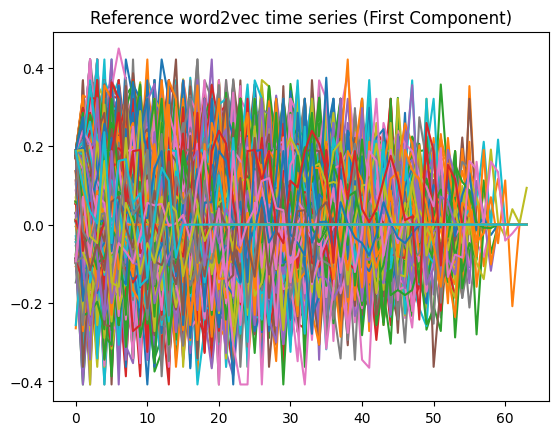

In [5]:
# getting word2vec embedding for train
ref_embedding_train=np.zeros((len(integer_encoded_train),max([len(i) for i in omega_text_words_train]),50))
for i in range(ref_embedding_train.shape[0]):
    sent=omega_text_words_train[i]
    for j in range(len(sent)):
        ref_embedding_train[i,j,:]=w2v_model.wv[omega_text_words_train[i][j]]


# getting word2vec embedding for test
ref_embedding_test=np.zeros((len(integer_encoded_test),max([len(i) for i in omega_text_words_test]),50))
for i in range(ref_embedding_test.shape[0]):
    sent=omega_text_words_test[i]
    for j in range(len(sent)):
        ref_embedding_test[i,j,:]=w2v_model.wv[omega_text_words_test[i][j]]


print("ref_embedding_train.shape: ",ref_embedding_train.shape)
print("ref_embedding_test.shape: ",ref_embedding_test.shape)


plt.figure()
for i in range(len(ref_embedding_test)):
    plt.plot(ref_embedding_test[i,:,0])
    plt.title("Reference word2vec time series (First Component)")     

In [6]:



# creating a tokenizer
t=Tokenizer()
t.fit_on_texts(text_list)
vocab_size = len(t.word_index) + 1




X_encoded_train= t.texts_to_sequences(text_list_train)
X_encoded_test= t.texts_to_sequences(text_list_test)

max_len=max(len(l) for l in X_encoded_train)
print("Maximum  Time series Size in Train Texts:", max_len)

X_train=pad_sequences(X_encoded_train,maxlen=max_len,padding='post')
X_test=pad_sequences(X_encoded_test,maxlen=max_len,padding='post')

y_train=onehot_encoded_train
y_test=onehot_encoded_test


base_size=50
embedding_matrix=np.zeros((vocab_size,base_size))


for word,i in t.word_index.items():
    temp=w2v_model.wv[word]
    if temp is not None:
        embedding_matrix[i]=temp

red_size=base_size
#-----------------------Autoencoder Compression-----------------------#
red_size = 25
random_state = 0
scaler=MinMaxScaler()
# emb_mat1=scaler.fit_transform(embedding_matrix)
emb_mat1=embedding_matrix
acti='relu'
acti_en='tanh'
input_vec = keras.Input(shape=(base_size,))
x = layers.Dense(red_size*4, activation=acti)(input_vec)
x= layers.Dense(red_size*2, activation=acti)(x)
encoded = layers.Dense(red_size, activation=acti_en,name='subversion')(x)
decoded = layers.Dense(red_size*2, activation=acti)(encoded)
decoded = layers.Dense(red_size*4, activation=acti)(decoded)
decoded = layers.Dense(base_size, activation='linear')(decoded)
autoencoder = keras.Model(input_vec, decoded)
autoencoder.compile(optimizer=Adam(lr=1e-4), loss='mse')

autoencoder.fit(emb_mat1, emb_mat1,
                epochs=20,shuffle=True,verbose=1,validation_split=0.2)


encoder = keras.Model(input_vec, encoded)
embedding_matrix=encoder.predict(emb_mat1)


#-----------------------Neural Embedding (Supervised now unlinke previous)-----------------------#

very_red_size=red_size
model=Sequential()
model.add(Embedding(vocab_size,red_size,weights=[embedding_matrix],input_length=max_len,trainable=True,name='embedder'))
# model.add(LayerNormalization())
# model.add(Dense(very_red_size,activation='linear',name='getter'))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(20,activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(num_classes,activation='softmax'))
model.compile(optimizer=Adam(lr=1e-3),loss='categorical_crossentropy',metrics=['acc'])
model.summary()
history=model.fit(X_train,y_train,epochs=40,verbose=2,batch_size=32,validation_data=(X_test,y_test))

Maximum  Time series Size in Train Texts: 66



Epoch 1/20



381/381 [==============================] - 2s 2ms/step - loss: 0.0087 - val_loss: 0.0043
Epoch 2/20
381/381 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0032
Epoch 3/20
381/381 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0028
Epoch 4/20
381/381 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0027
Epoch 5/20
381/381 [==============================] - 1s 2ms/step - loss: 0.0038 - val_loss: 0.0027
Epoch 6/20
381/381 [==============================] - 1s 2ms/step - loss: 0.0038 - val_loss: 0.0026
Epoch 7/20
381/381 [==============================] - 1s 2ms/step - loss: 0.0037 - val_loss: 0.0026
Epoch 8/20
381/381 [==============================] - 1s 2ms/step - loss: 0.0037 - val_loss: 0.0026
Epoch 9/20
381/381 [==============================] - 1s 2ms/step - loss: 0.0037 - val_loss: 0.0026
Epoch 10/20
381/381 [==============================] - 1s 2ms/step - loss: 0.0036 - val_loss: 0.0025
Epoch 11/2

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        (None, 66, 25)            380325    
                                                                 
 dropout (Dropout)           (None, 66, 25)            0         
                                                                 
 flatten (Flatten)           (None, 1650)              0         
                                                                 
 dense_5 (Dense)             (None, 20)                33020     
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_6 (Dense)             (None, 6)                 126       
                                                                 
Total params: 413471 (1.58 MB)
Trainable params: 413471 

300/300 - 2s - loss: 1.5911 - acc: 0.3379 - val_loss: 1.5459 - val_acc: 0.4655 - 2s/epoch - 6ms/step
Epoch 2/40
300/300 - 1s - loss: 1.4589 - acc: 0.4457 - val_loss: 1.3473 - val_acc: 0.5145 - 1s/epoch - 3ms/step
Epoch 3/40
300/300 - 1s - loss: 1.0993 - acc: 0.6054 - val_loss: 1.0137 - val_acc: 0.6528 - 1s/epoch - 3ms/step
Epoch 4/40
300/300 - 1s - loss: 0.7353 - acc: 0.7557 - val_loss: 0.8234 - val_acc: 0.7236 - 988ms/epoch - 3ms/step
Epoch 5/40
300/300 - 1s - loss: 0.5112 - acc: 0.8370 - val_loss: 0.7187 - val_acc: 0.7598 - 969ms/epoch - 3ms/step
Epoch 6/40
300/300 - 1s - loss: 0.3588 - acc: 0.8859 - val_loss: 0.6583 - val_acc: 0.7827 - 963ms/epoch - 3ms/step
Epoch 7/40
300/300 - 1s - loss: 0.2432 - acc: 0.9270 - val_loss: 0.6110 - val_acc: 0.8072 - 1s/epoch - 3ms/step
Epoch 8/40
300/300 - 1s - loss: 0.1659 - acc: 0.9550 - val_loss: 0.6092 - val_acc: 0.8112 - 1s/epoch - 4ms/step
Epoch 9/40
300/300 - 1s - loss: 0.1241 - acc: 0.9647 - val_loss: 0.6255 - val_acc: 0.8130 - 1s/epoch - 3ms

In [7]:
layer_output=model.get_layer('embedder').output
intermediate_model=keras.models.Model(inputs=model.input,outputs=layer_output)
intermediate_prediction_train=intermediate_model.predict(X_train)
scaler=100.0
rough_timeseries_train=scaler*intermediate_prediction_train
print("Train rough time series shape: ",rough_timeseries_train.shape)


intermediate_prediction_test=intermediate_model.predict(X_test)
scaler=100.0
rough_timeseries_test=scaler*intermediate_prediction_test
print("Test rough time series shape: ",rough_timeseries_test.shape)

300/300 [==============================] - 0s 967us/step
Train rough time series shape:  (9600, 66, 25)
200/200 [==============================] - 0s 824us/step
Test rough time series shape:  (6400, 66, 25)


In [8]:
max_size=max([len(i) for i in omega_text_words])+200

# TRAIN 

time_stretched_train=np.zeros((len(y_train),max_size,very_red_size)) #stretches the vector over zero padding
time_stretched2_train=np.zeros((len(y_train),max_size,very_red_size)) #stretches the vector over zero padding but also stretches 
                                                            # a scalar over whole zero padding

for i in range(len(y_train)):
    data=rough_timeseries_train[i]
    indo=omega_text_words_train[i]
    sub_data=data[:len(omega_text_words_train[i]),:]
    if (len(indo)>1):
        data_stretched=np.zeros((max_size,very_red_size))
        for k in range(data_stretched.shape[1]):
            strectchy=librosa.resample(sub_data[:,k], sub_data.shape[0], max_size)
            data_stretched[:,k]=strectchy[:max_size]

        time_stretched_train[i,:,:]=data_stretched
        time_stretched2_train[i,:,:]=data_stretched

    if (len(indo)==1):
        sub_data_val=sub_data[:,:very_red_size]
        time_stretched_train[i,:sub_data_val.shape[0],:]=sub_data_val

        data_stretched=np.zeros((max_size,very_red_size))

        for k in range(data_stretched.shape[1]):
            stretchy=librosa.core.resample(sub_data_val[:,k], sub_data_val.shape[0], max_size)
            data_stretched[:,k]=strectchy[:max_size]

        time_stretched2_train[i,:,:]=data_stretched


# TEST

time_stretched_test=np.zeros((len(y_test),max_size,very_red_size)) #stretches the vector over zero padding
time_stretched2_test=np.zeros((len(y_test),max_size,very_red_size)) #stretches the vector over zero padding but also stretches

for i in range(len(y_test)):
    data=rough_timeseries_test[i]
    indo=omega_text_words_test[i]
    sub_data=data[:len(omega_text_words_test[i]),:]
    if (len(indo)>1):
        data_stretched=np.zeros((max_size,very_red_size))
        for k in range(data_stretched.shape[1]):
            strectchy=librosa.core.resample(sub_data[:,k], sub_data.shape[0], max_size)
            data_stretched[:,k]=strectchy[:max_size]

        time_stretched_test[i,:,:]=data_stretched
        time_stretched2_test[i,:,:]=data_stretched

    if (len(indo)==1):
        sub_data_val=sub_data[:,:very_red_size]
        time_stretched_test[i,:sub_data_val.shape[0],:]=sub_data_val

        data_stretched=np.zeros((max_size,very_red_size))

        for k in range(data_stretched.shape[1]):
            stretchy=librosa.core.resample(sub_data_val[:,k], sub_data_val.shape[0], max_size)
            data_stretched[:,k]=strectchy[:max_size]

        time_stretched2_test[i,:,:]=data_stretched


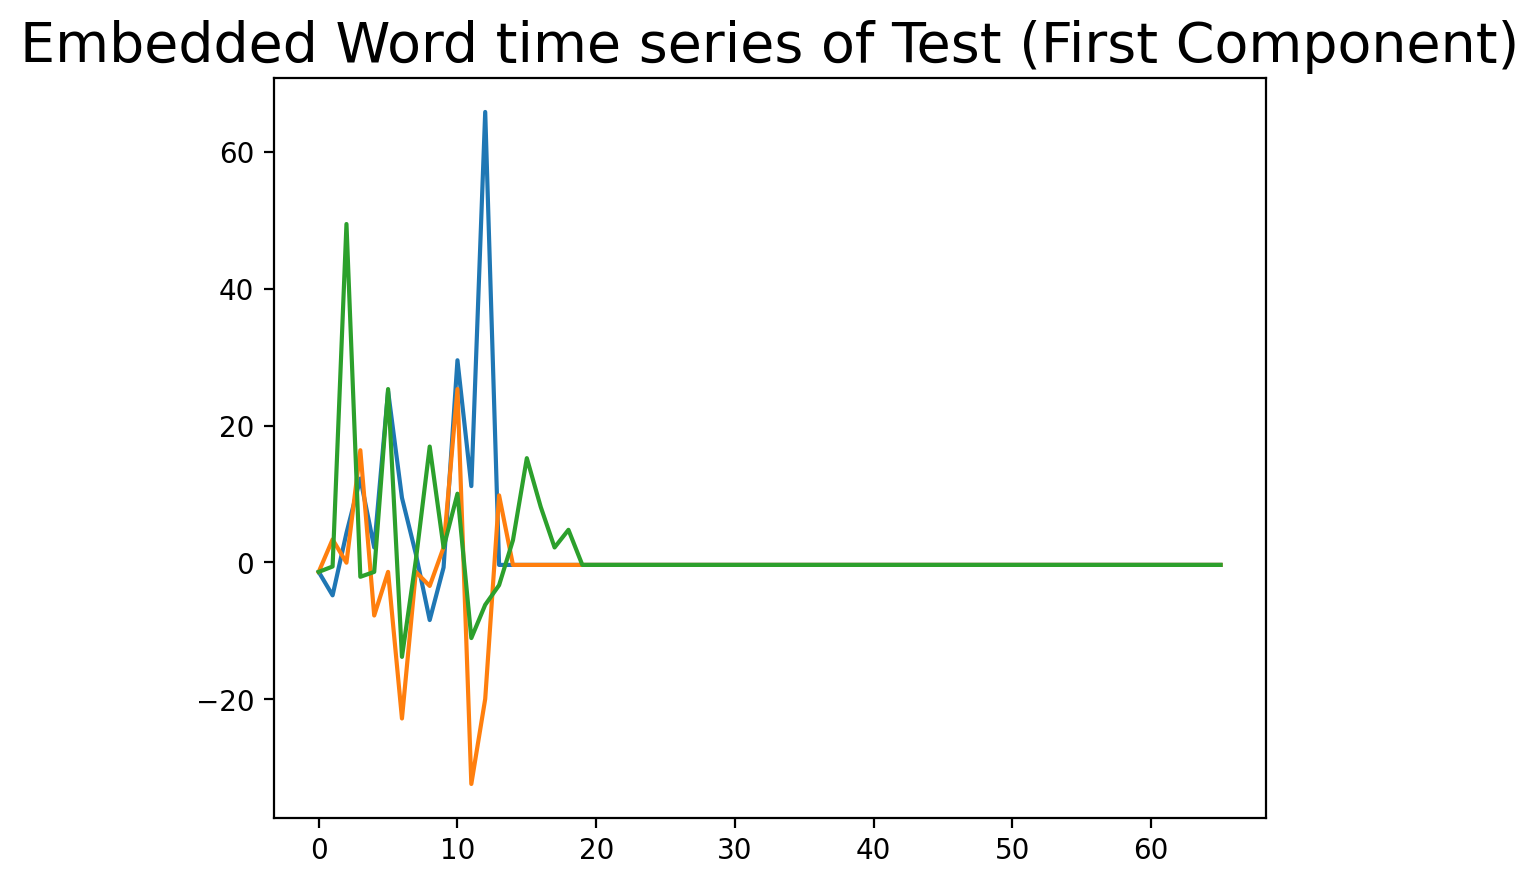

In [9]:
plt.figure(dpi=200)
for i in [3,4,5]:
    plt.plot(rough_timeseries_test[i,:,0])
    plt.title("Embedded Word time series of Test (First Component)", fontsize=20)

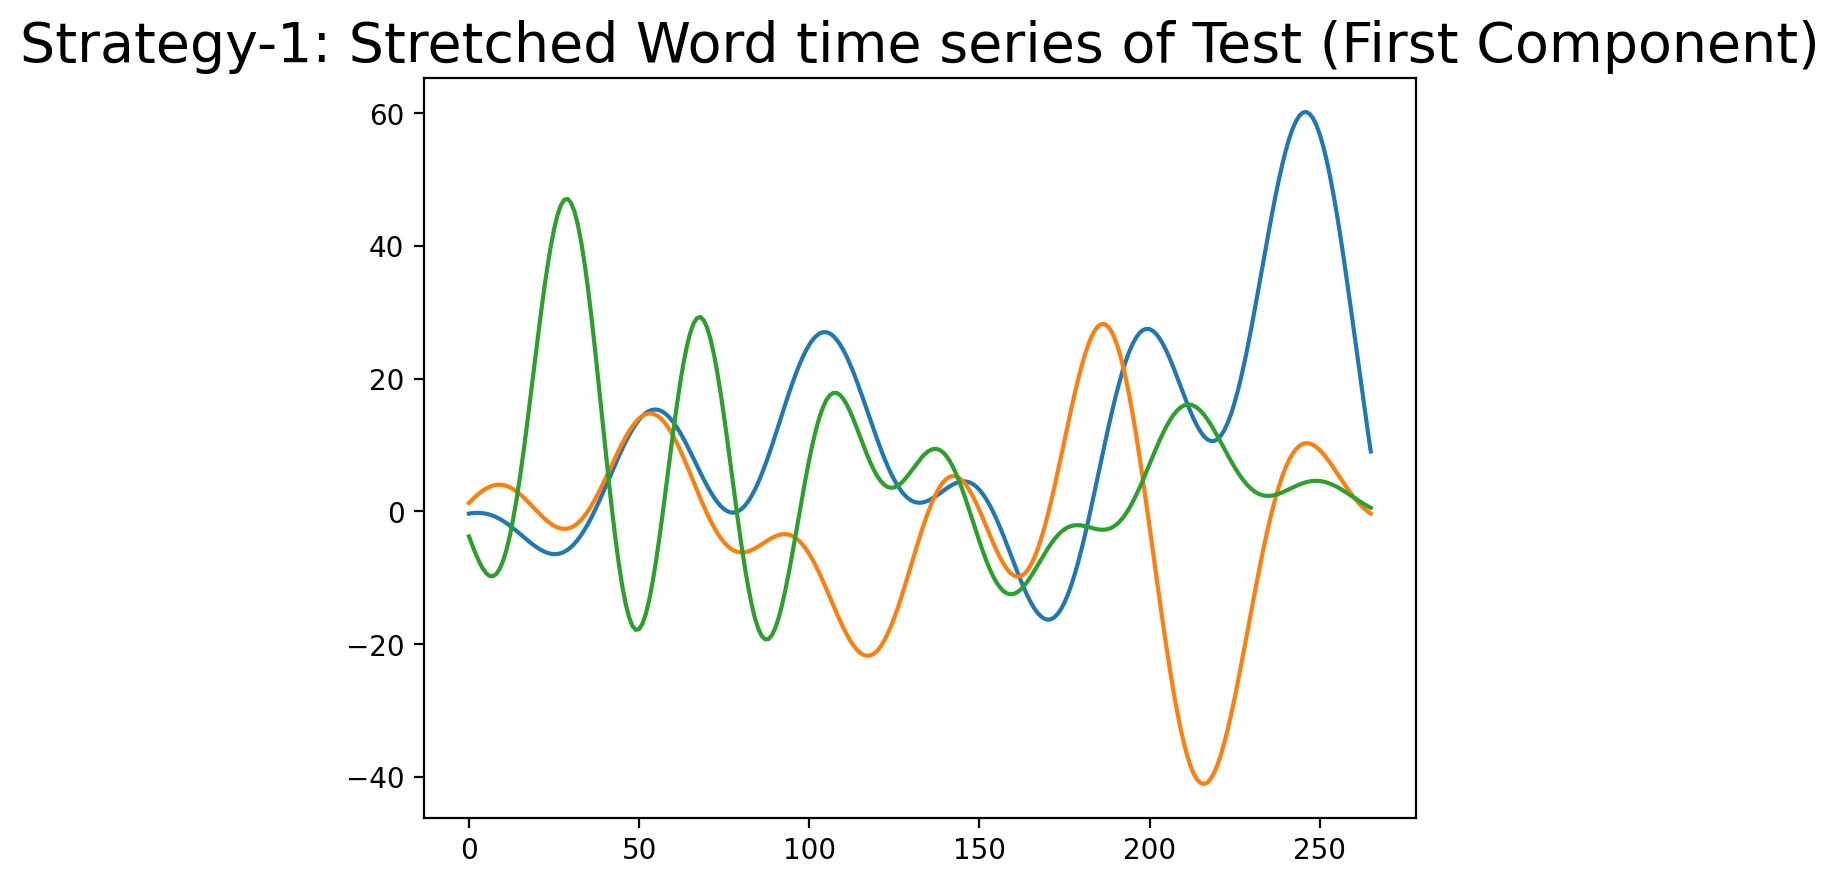

In [10]:
plt.figure(dpi=200)
for i in [3,4,5]:
    plt.plot(time_stretched_test[i,:,0])
    plt.title("Strategy-1: Stretched Word time series of Test (First Component)", fontsize=20)

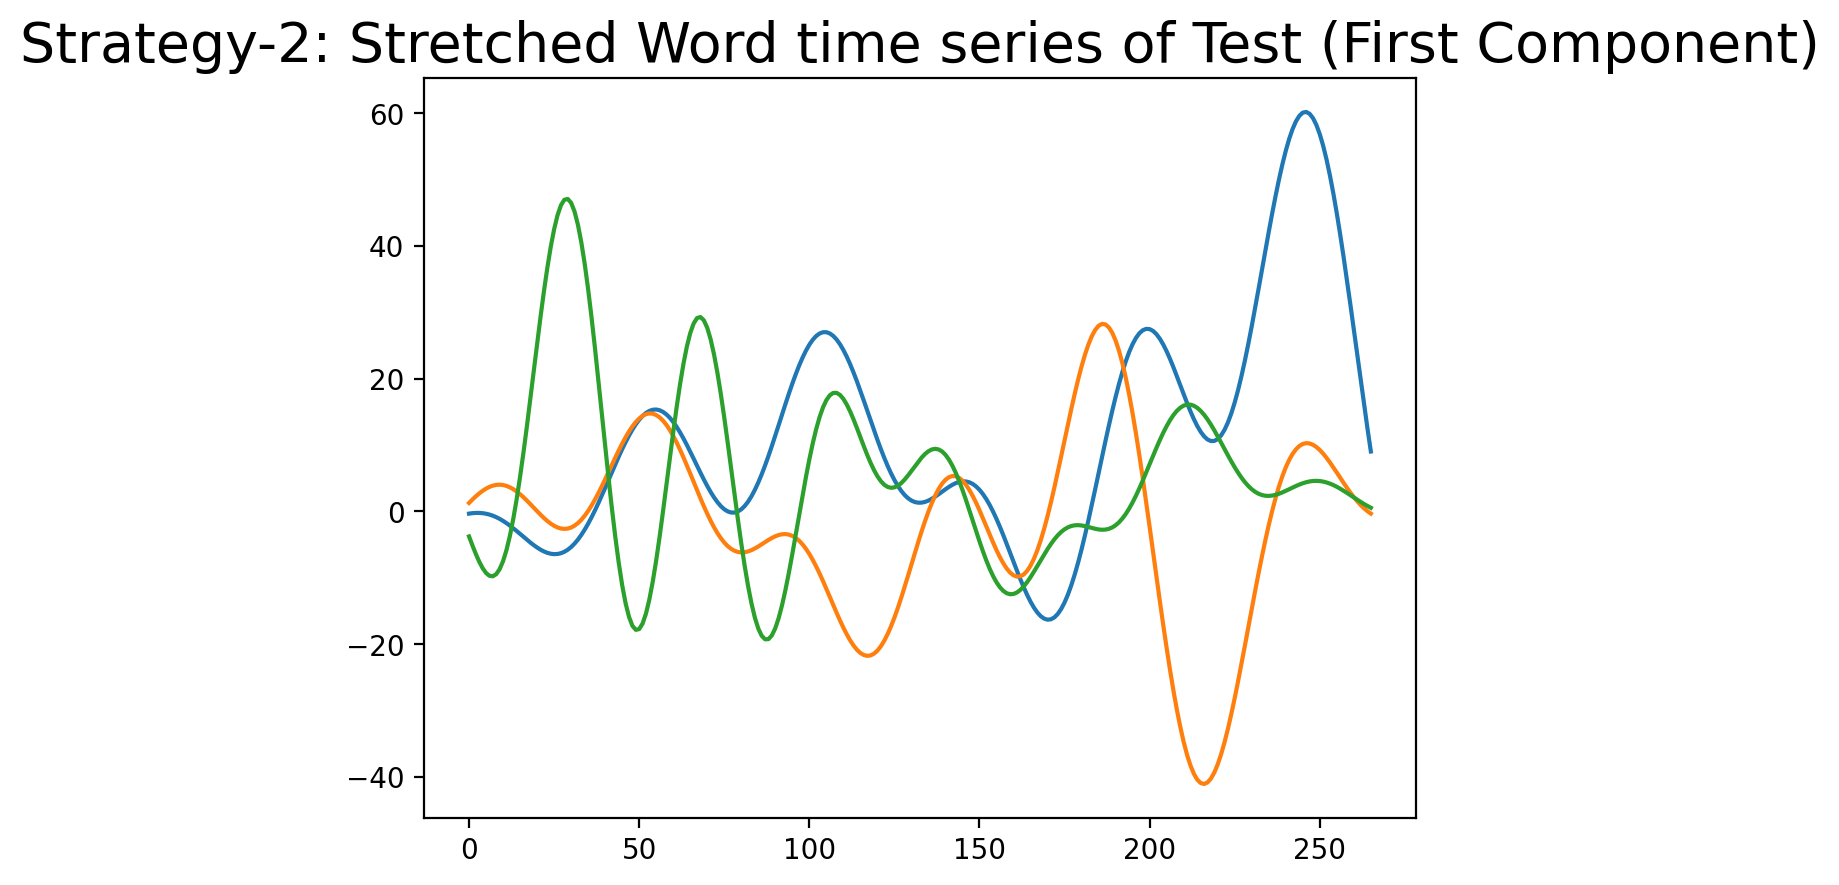

In [11]:
plt.figure(dpi=200)
for i in [3,4,5]:
    plt.plot(time_stretched2_test[i,:,0])
    plt.title("Strategy-2: Stretched Word time series of Test (First Component)", fontsize=20)

In [12]:
print("Train Signal Features Shape: ",time_stretched2_train.shape)
print("Test Signal Features Shape: ",time_stretched2_test.shape)

Train Signal Features Shape:  (9600, 266, 25)
Test Signal Features Shape:  (6400, 266, 25)


In [13]:
# create a tensor dataset
train_dataset = torch.utils.data.TensorDataset(torch.Tensor(time_stretched2_train),torch.Tensor(integer_encoded_train))
test_dataset = torch.utils.data.TensorDataset(torch.Tensor(time_stretched2_test),torch.Tensor(integer_encoded_test))

# create a data loader
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=True)


In [72]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class TransformerEncoder(nn.Module):
    def __init__(self, embed_size, head_size, num_heads, ff_dim, dropout):
        super(TransformerEncoder, self).__init__()
        self.norm1 = nn.LayerNorm(embed_size)  # Corrected
        self.attention = nn.MultiheadAttention(embed_dim=embed_size, num_heads=num_heads, dropout=dropout)
        self.norm2 = nn.LayerNorm(embed_size)  # Corrected
        self.ff = nn.Sequential(
            nn.Conv1d(in_channels=embed_size, out_channels=ff_dim, kernel_size=1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(in_channels=ff_dim, out_channels=embed_size, kernel_size=1)
        )

    def forward(self, x):
        # permute dimnesion from (0,1,2) to (0,2,1)
        # Normalization and Attention
        x_norm = self.norm1(x)
        x_att, _ = self.attention(x_norm, x_norm, x_norm)
        x = x + x_att

        # Feed Forward Part
        x_norm = self.norm2(x)
        x_ff = self.ff(x_norm.transpose(1, 2)).transpose(1, 2)
        x = x + x_ff

        return x

class TransformerModel(nn.Module):
    def __init__(self, max_size, embed_size, head_size, num_heads, ff_dim, num_transformer_blocks, num_classes, dropout):
        super(TransformerModel, self).__init__()
        self.encoders = nn.ModuleList([
            TransformerEncoder(embed_size, head_size, num_heads, ff_dim, dropout) 
            for _ in range(num_transformer_blocks)
        ])
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(embed_size, 20),
            nn.ReLU(),
            nn.BatchNorm1d(20),
            nn.Linear(20, num_classes)
        )

    def forward(self, x):
        for encoder in self.encoders:
            x = encoder(x)
        x = self.pooling(x.transpose(1, 2)).squeeze(-1)
        x = self.fc(x)
        return x

# Example of creating a model
max_size = max_size # Adjust as needed
embed_size = 25 # Same as head_size in your Keras model
head_size = 66
num_heads = 5
ff_dim = 32
num_transformer_blocks = 3
num_classes = 10 # Adjust as needed
dropout = 0.2

model = TransformerModel(max_size, embed_size, head_size, num_heads, ff_dim, num_transformer_blocks, num_classes, dropout).to(device)

# Example optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_function = nn.CrossEntropyLoss()
total_epochs= 3
for epoch in range(total_epochs):
    run_loss = 0.0
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        y=y.squeeze(1)
        loss = loss_function(y_pred, y.long())
        loss.backward()
        optimizer.step()
        run_loss += loss.item()

    if epoch % 1 == 0:
        print(f'Epoch: {epoch}/{total_epochs}, Loss: {run_loss / len(train_loader)}')


Epoch: 0/3, Loss: 0.917987712919712
Epoch: 1/3, Loss: 0.18198411708076795
Epoch: 2/3, Loss: 0.1198191060187916


<Axes: >

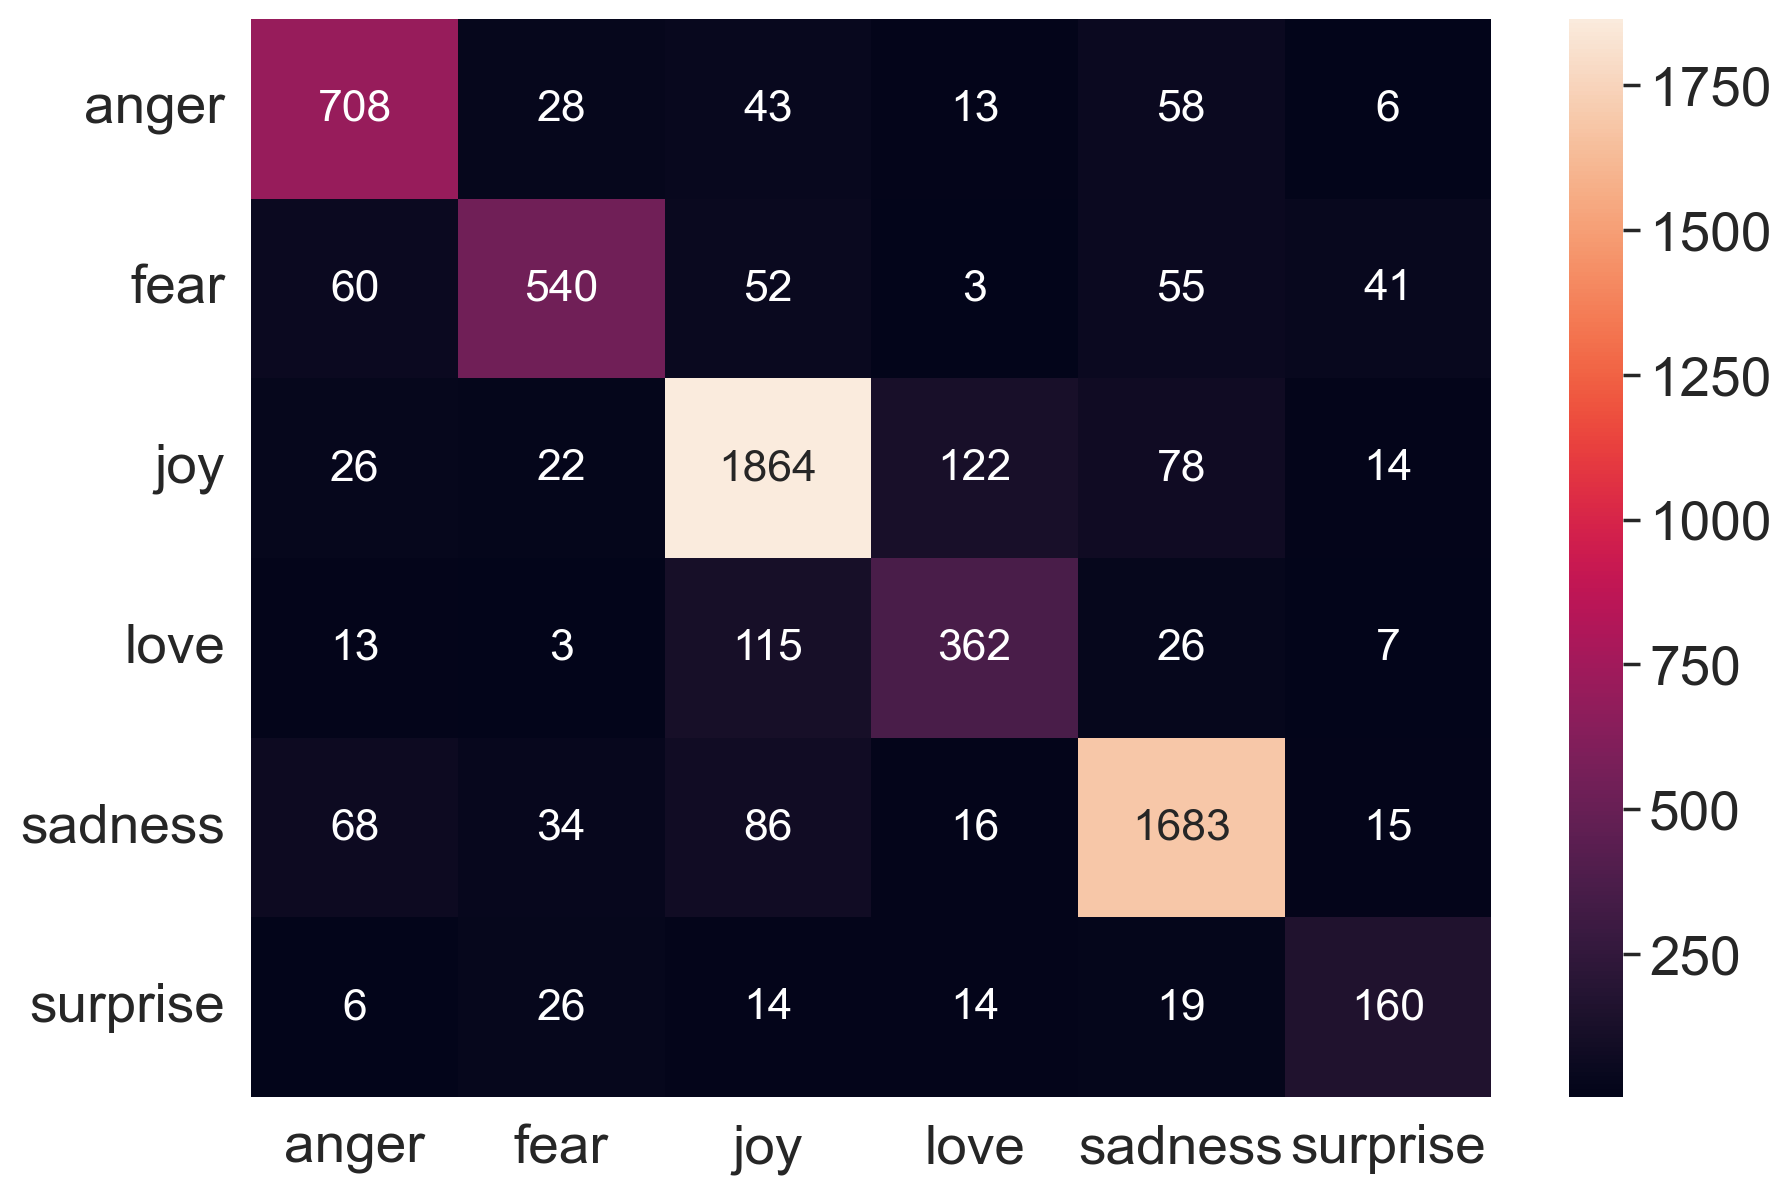

In [75]:
ref=[]
predictions=[]
for batch in test_loader:
    x, targets = batch
    x = x.to(device)
    targets = targets.to(device)
    outputs = model(x)
    # outputs = torch.squeeze(outputs)
    targets = targets.squeeze(1).long()
    predicted_labels = torch.argmax(outputs, dim=1)
    ref.extend(targets.cpu().numpy())
    predictions.extend(predicted_labels.cpu().numpy())



cm=confusion_matrix(ref,predictions)


label_names=[]
for key,_ in mapping.items():
    label_names.append(key)

    
#plot confusion matrix

df_cm = pd.DataFrame(cm, label_names,label_names)
plt.figure(figsize = (10,7),dpi=200)
sn.set(font_scale=1.8)  # Increase the font size for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='d') # font size

In [76]:
print(classification_report(ref, predictions,digits=4))

              precision    recall  f1-score   support

           0     0.8036    0.8271    0.8152       856
           1     0.8270    0.7190    0.7692       751
           2     0.8574    0.8768    0.8670      2126
           3     0.6830    0.6882    0.6856       526
           4     0.8770    0.8849    0.8809      1902
           5     0.6584    0.6695    0.6639       239

    accuracy                         0.8308      6400
   macro avg     0.7844    0.7776    0.7803      6400
weighted avg     0.8307    0.8308    0.8302      6400

